## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.functional as F
import itertools


from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2
import timeit

use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("OK")

OK


### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [2]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 42.18 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


Check that the repository is there:

In [3]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [7]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/drill/n03239726_5392.JPEG,5
1,imagenet10/train_set/cat/n02123159_7464.JPEG,3
2,imagenet10/train_set/orange/n07747607_18029.JPEG,9
3,imagenet10/train_set/dumbbell/n03255030_3032.JPEG,6
4,imagenet10/train_set/mug/n03797390_3057.JPEG,8


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [10]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:39<00:00, 225.25it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10
test_split = 0.20

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)
test_size = int(len(data_df)*test_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)


You will need to create DataLoaders for the datasets.

In [0]:
train_data_loader = torch.utils.data.DataLoader(ins_dataset_train, batch_size=10, shuffle=True,  num_workers=4)
test_data_loader = torch.utils.data.DataLoader(ins_dataset_test, batch_size=2, shuffle=True,  num_workers=4)
valid_data_loader = torch.utils.data.DataLoader(ins_dataset_valid, batch_size=10, shuffle=True,  num_workers=4)

A framework for the ConvNet model, missing all layers except the final fully-connected layer:

In [0]:
# The optimization
class ConvNet_opt(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet_opt, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=2),nn.ReLU(),nn.MaxPool2d(3,2,0))
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2),nn.ReLU(),nn.MaxPool2d(3,2,0))
    self.conv3 = nn.Sequential(nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1),nn.ReLU())
    self.conv4 = nn.Sequential(nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(3,2,0))
    self.conv5 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2))
    self.dropout = nn.Dropout(p=0.3)
    self.fc1 = nn.Linear(1152, 684)
    self.fc2 = nn.Linear(684, 512)
    self.fc3 = nn.Linear(512, num_classes)

  def forward(self, x):
    
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return out

In [0]:
class ConvNet_2layer(nn.Module):
  def __init__(self, num_classes=10):
      super(ConvNet_2layer, self).__init__()
  
      # Add network layers here
      # input shape(256,256,3)

      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
        
      # Random weight initialisation
      torch.nn.init.xavier_uniform(self.conv1[0].weight)

      self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=24,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))

      self.fc1 = nn.Linear(24*62*62,512)
      self.fc2 = nn.Linear(512, num_classes)
      self.dropout = nn.Dropout(p=0.3)
        
  def forward(self, x):
    # Complete the graph
    x = self.conv1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.dropout(x)

    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    x = self.fc2(x)
        
    return x

In [0]:
class ConvNet_3layer(nn.Module):
  def __init__(self, num_classes=10):
      super(ConvNet_3layer, self).__init__()
  
      # Add network layers here
      # input shape(256,256,3)

      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
        
      # Random weight initialisation
      torch.nn.init.xavier_uniform(self.conv1[0].weight)

      self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=24,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv3 = nn.Sequential(nn.Conv2d(in_channels=24,out_channels=32,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2)) 

      self.fc1 = nn.Linear(32*29*29,512)
      self.fc2 = nn.Linear(512, num_classes)
      self.dropout = nn.Dropout(p=0.3)
        
  def forward(self, x):
    # Complete the graph
    x = self.conv1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.dropout(x)

    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    x = self.fc2(x)
        
    return x

In [0]:
class ConvNet_4layer(nn.Module):
  def __init__(self, num_classes=10):
      super(ConvNet_4layer, self).__init__()
  
      # Add network layers here
      # input shape(256,256,3)

      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
        
      # Random weight initialisation
      torch.nn.init.xavier_uniform(self.conv1[0].weight)

      self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=24,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv3 = nn.Sequential(nn.Conv2d(in_channels=24,out_channels=32,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=40,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(2))

      self.fc1 = nn.Linear(40*13*13,512)
      self.fc2 = nn.Linear(512, num_classes)
      self.dropout = nn.Dropout(p=0.3)
        
  def forward(self, x):
    # Complete the graph
    x = self.conv1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.dropout(x)
        
    # Modification
    x = self.conv4(x)
    x = self.dropout(x)

    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    x = self.fc2(x)
        
    return x

class ConvNet_4layer_opt(nn.Module):
  def __init__(self, num_classes=10):
      super(ConvNet_4layer_opt, self).__init__()
  
      # Add network layers here
      # input shape(256,256,3)

      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
        
      # Random weight initialisation
      torch.nn.init.xavier_uniform(self.conv1[0].weight)

      self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=24,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv3 = nn.Sequential(nn.Conv2d(in_channels=24,out_channels=32,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=40,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(2))

      self.fc1 = nn.Linear(40*13*13,3380)
      self.fc2 = nn.Linear(3380, 512)
      self.fc3 = nn.Linear(512, num_classes)

      self.dropout = nn.Dropout(p=0.3)
        
  def forward(self, x):
    # Complete the graph
    x = self.conv1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.dropout(x)
    x = self.conv4(x)
    x = self.dropout(x)

    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
        
    return x

In [0]:
class ConvNet_5layer(nn.Module):
  def __init__(self, num_classes=10):
      super(ConvNet_5layer, self).__init__()
  
      # Add network layers here
      # input shape(256,256,3)

      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
        
      # Random weight initialisation
      torch.nn.init.xavier_uniform(self.conv1[0].weight)

      self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=24,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv3 = nn.Sequential(nn.Conv2d(in_channels=24,out_channels=32,kernel_size=4,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=40,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(2))
      self.conv5 = nn.Sequential(nn.Conv2d(in_channels=40,out_channels=48,kernel_size=3,stride=1),nn.ReLU(),nn.MaxPool2d(2)) 

      self.fc1 = nn.Linear(48*5*5,512)
      self.fc2 = nn.Linear(512, num_classes)
      self.dropout = nn.Dropout(p=0.3)
        
  def forward(self, x):
    # Complete the graph
    x = self.conv1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.dropout(x)
        
    # Modification
    x = self.conv4(x)
    x = self.dropout(x)
    x = self.conv5(x)
    x = self.dropout(x)

    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    x = self.fc2(x)
        
    return x

In [0]:
# ==============================================================================================================================

In [0]:
def plot_acc_loss(train_acc, valid_acc, train_loss, valid_loss):
  x1 = range(0, 10)
  x2 = range(0, 10)
  plt.figure(figsize=(20, 20))
  plt.subplot(2, 2, 1)
  plt.plot(x1, train_acc, 'o-', label='train_acc')
  plt.plot(x1, valid_acc, 'o-', label='valid_acc')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Train accuracy vs. Valid accuracy')
  plt.subplot(2, 2, 2)
  plt.plot(x2, train_loss, '.-', label='train_loss')
  plt.plot(x2, valid_loss, '.-', label='valid_loss')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Train loss vs. Valid loss')
  plt.show()

In [39]:
# cnn = ConvNet_5layer()
cnn = ConvNet_4layer()
# cnn = ConvNet_4layer_opt()
# cnn = ConvNet_3layer()
# cnn = ConvNet_2layer()
# cnn = ConvNet_opt()

if use_cuda and torch.cuda.is_available():
  cnn.cuda()

# optimizer
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.001,momentum=0.9)
# optimizer = torch.optim.Adam(cnn.parameters(),lr=0.0001)

# loss function
loss_func = nn.CrossEntropyLoss()

# Set up the Epoch number
EPOCH = 10

# Validate the data accuracy
def valid_data():
  cnn.eval()
  valid_acc = 0.0
  valid_loss = 0.0
  for i, data in enumerate(valid_data_loader):
    x,y = data
    images = Variable(x)
    labels = Variable(y)
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    # Predict classes using images from the test set
    output = cnn(images)
    loss = loss_func(output,labels)
    _, prediction = torch.max(output.data, 1)

    valid_loss += loss.item()
    valid_acc += torch.sum(prediction == labels.data)

  # Compute the average acc and loss over all valid 
  valid_acc = valid_acc / valid_size
  return valid_acc,valid_loss

# Training loop
def train_data():
  best_acc = 0.0
  train_acc_ = [] 
  valid_acc_ = [] 
  train_loss_ = []
  valid_loss_ = []
  conv_init = cnn.conv1[0].weight.cpu().detach().clone().numpy()

  for epoch in range(EPOCH):
    train_acc = 0.0
    train_loss = 0.0
    for i ,data in enumerate(train_data_loader):
      # Training and Testing Batch size
      images,labels = data
      images = Variable(images)
      labels = Variable(labels)
      if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      
      # Zero the parameter gradients means to reset them from any previous values. By default, gradients accumulate!
      optimizer.zero_grad()

      # Input Training Data
      # Passing inputs to the model calls the forward() function of the Module class, and the outputs value contains the return value of forward()
      outputs = cnn(images)
      # Compute the loss based on the true labels  
      loss = loss_func(outputs,labels)
      
      # Backpropagate the error with respect to the loss
      loss.backward()
    
      # Updates the parameters based on current gradients and update rule;
      # Original used: SGD(); Modified: Adam()
      optimizer.step()

      # Compute the loss
      train_loss += loss.item()

      _, prediction = torch.max(outputs.data, 1)
      train_acc += torch.sum(prediction == labels.data)

    if epoch == (EPOCH/2) - 1:
      # Filter Visualization
      conv_half = cnn.conv1[0].weight.cpu().detach().clone().numpy()

    
    # Compute the training accuracy
    train_acc = train_acc / train_size
    
    # Evaluate on the valid set
    valid_acc,valid_loss = valid_data()

    # Print the accuracy and loss
    print("Epoch {}, Train Accuracy: {} , Train Loss:{}, Validational Accuracy: {}, Validational Loss: {}".format(epoch, train_acc, train_loss/1000, valid_acc, valid_loss/1000))

    train_acc = train_acc.cpu().numpy()
    valid_acc = valid_acc.cpu().numpy()

    train_acc_.append(train_acc)
    valid_acc_.append(valid_acc)
    train_loss_.append(train_loss/6300)
    valid_loss_.append(valid_loss/900)
  
  plot_acc_loss(train_acc_, valid_acc_, train_loss_, valid_loss_)
  # Filter Visualization
  conv_end = cnn.conv1[0].weight.cpu().detach().clone().numpy()
  
  return conv_init, conv_half, conv_end


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train Accuracy: 0.24904760718345642 , Train Loss:1.2680527762174607, Validational Accuracy: 0.2944444417953491, Validational Loss: 0.18325990104675294
Epoch 1, Train Accuracy: 0.32904762029647827 , Train Loss:1.1635501641631127, Validational Accuracy: 0.3888888955116272, Validational Loss: 0.15755254256725312
Epoch 2, Train Accuracy: 0.3941269814968109 , Train Loss:1.0816852172613145, Validational Accuracy: 0.42888888716697693, Validational Loss: 0.1483190360069275
Epoch 3, Train Accuracy: 0.44079363346099854 , Train Loss:1.016174080133438, Validational Accuracy: 0.44333335757255554, Validational Loss: 0.1430212973356247
Epoch 4, Train Accuracy: 0.4855555295944214 , Train Loss:0.9445226862430572, Validational Accuracy: 0.46444445848464966, Validational Loss: 0.14013505709171295
Epoch 5, Train Accuracy: 0.5277777314186096 , Train Loss:0.8623359166979789, Validational Accuracy: 0.5133333206176758, Validational Loss: 0.12538813310861588
Epoch 6, Train Accuracy: 0.5768253803253174

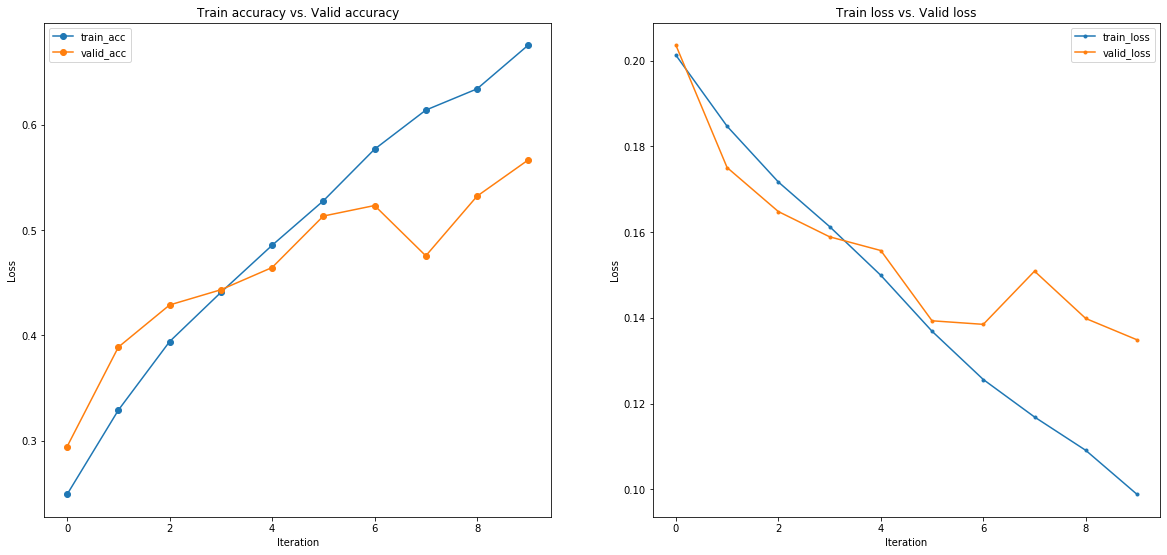

In [40]:
# gpu_train_time = timeit.timeit(
#     "train_data()",
#     number=1,
#     globals=globals(),
# )
conv_init, conv_half, conv_end = train_data()

In [27]:
# gpu_train_time

1325.1180449419999

In [31]:
# Save and Load the model
torch.save(cnn.state_dict(), 'model.pth')
cnn.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [0]:
# Using the Testdata to test the model
def test_data():
  # cnn.eval()
  test_acc = 0.0
  test_loss = 0.0

  with torch.no_grad():
    for i, data in enumerate(test_data_loader):
      x,y = data
      images = Variable(x)
      labels = Variable(y)
      if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      
      # Predict classes using images from the test set
      output = cnn(images)
      loss = loss_func(output,labels)
      _, prediction = torch.max(output.data, 1)

      test_loss += loss.item()

      labels = labels.cpu()
      prediction = prediction.cpu()
      
      test_acc += torch.sum(prediction == labels.data)

      labels = labels.numpy()
      prediction = prediction.numpy()

      if i == 0:
        y_true = labels
        y_pred = prediction
      else:
        y_true = np.append(y_true,labels)
        y_pred = np.append(y_pred,prediction)

    # Compute the average accuracy over all test images
    test_acc = test_acc / test_size

    # Also return the confusion matrix
    cm = confusion_matrix(y_true,y_pred)
    test_loss = test_loss/1800
    
    return test_acc,test_loss,cm

In [0]:
# print the test accuracy
test_acc,test_loss,cm = test_data()

In [0]:
# Plot a fancy Confusion Matrix
def plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix very prettily.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  plt.figure(figsize=(12, 8), dpi=70)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)

  # Specify the tick marks and axis text
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=90)
  plt.yticks(tick_marks, class_names)

  # The data formatting
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
    
  # Print the text of the matrix, adjusting text colour for display
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

Confusion matrix, without normalization


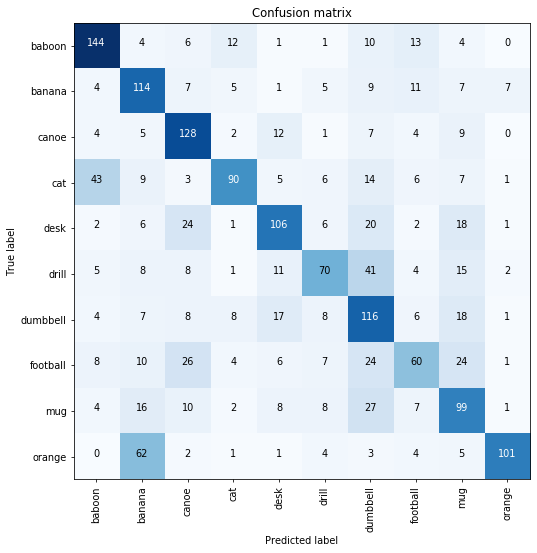

Test Accuracy: 
tensor(0.5711)
Test Loss: 
0.6829549634787772


In [44]:
plot_confusion_matrix(cm, class_names)
print("Test Accuracy: ")
print(test_acc)
print("Test Loss: ")
print(test_loss)

In [0]:
# ===================================================================================================================================================================

In [0]:
# Filter visualisation
'''
filter_ = 
cnn.conv1[0].weight.cpu().detach().clone().numpy()
cnn.conv2[0].weight.cpu().detach().clone().numpy()
cnn.conv3[0].weight.cpu().detach().clone().numpy()
'''
# def normalize(x):
#   return (x-np.min(x))/(np.max(x)-np.min(x))

def filter_visual(filter_visual):
  fig1 = plt.figure()
  # print(layer_name + state)
  plt.figure(figsize=(15,15))
  for idx, filt in enumerate(filter_visual):
      plt.subplot(3,16,idx + 1)
      plt.imshow(filt[0,:,:],cmap='gray')
      plt.axis('off')
      
  fig1.show()
  fig2 = plt.figure()
  plt.figure(figsize=(15,15))
  for idx, filt in enumerate(filter_visual):
      plt.subplot(3,16,idx + 1)
      plt.imshow(filt[1,:,:],cmap='gray')
      plt.axis('off')
  fig2.show()

  fig3 = plt.figure()
  plt.figure(figsize=(15,15))
  for idx, filt in enumerate(filter_visual):
      plt.subplot(3,16,idx + 1)
      plt.imshow(filt[2,:,:],cmap='gray')
      plt.axis('off')
  fig3.show()


<Figure size 432x288 with 0 Axes>

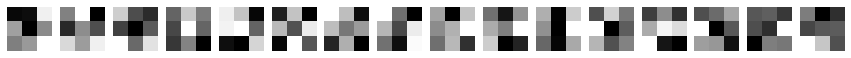

<Figure size 432x288 with 0 Axes>

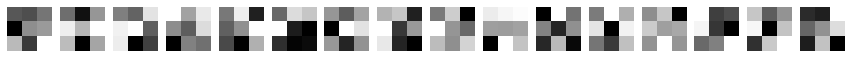

<Figure size 432x288 with 0 Axes>

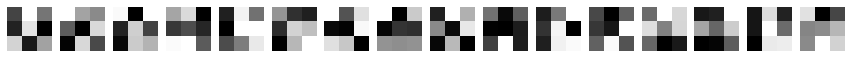

<Figure size 432x288 with 0 Axes>

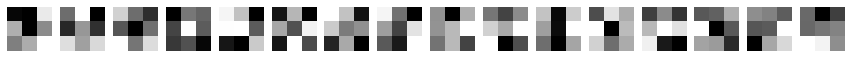

<Figure size 432x288 with 0 Axes>

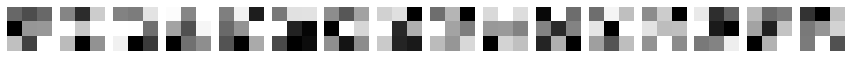

<Figure size 432x288 with 0 Axes>

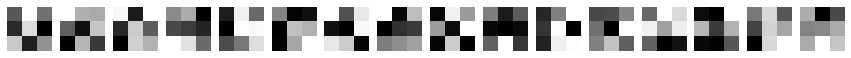

<Figure size 432x288 with 0 Axes>

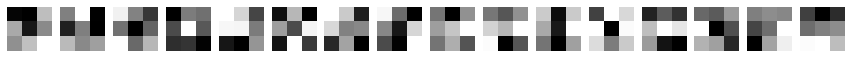

<Figure size 432x288 with 0 Axes>

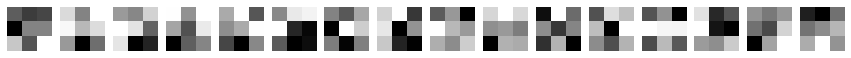

<Figure size 432x288 with 0 Axes>

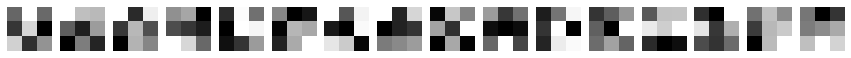

In [0]:
filter_visual(conv_init)
filter_visual(conv_half)
filter_visual(conv_end)

In [0]:
# Feature Map
def get_activation():
  for i ,data in enumerate(test_data_loader):
    images,labels = data
    images = Variable(images)
    labels = Variable(labels)
    images = images.cuda()

    conv1_activs = cnn.conv1[0].forward(images)
    conv_temp = cnn.conv1.forward(images)
    conv2_activs = cnn.conv2[0].forward(conv_temp)
    conv_temp = cnn.conv2.forward(conv_temp)
    conv3_activs = cnn.conv3[0].forward(conv_temp)
    conv_temp = cnn.conv3.forward(conv_temp)
    conv4_activs = cnn.conv4[0].forward(conv_temp)

  conv1 = conv1_activs.cpu().detach().clone().numpy()
  conv2 = conv2_activs.cpu().detach().clone().numpy()
  conv3 = conv3_activs.cpu().detach().clone().numpy()
  conv4 = conv4_activs.cpu().detach().clone().numpy()
  
  return conv1, conv2, conv3, conv4

# Using register_forward_hook
def get_activation_hook():
  def hook_fn_forward(module,input,output):
    print('hook working')

  modules = cnn.named_children()

  for i ,data in enumerate(test_data_loader):
    images,labels = data
    images = Variable(images)
    labels = Variable(labels)
    images = images.cuda()

  for name,module in modules:
    h = module.register_forward_hook(hook_fn_forward)
    if name == 'conv1':
      activate1 = module(images)
    if name == 'conv2':
      activate2 = module(activate1)
    if name == 'conv3':
      activate3 = module(activate2)
    if name == 'conv4':
      activate4 = module(activate3)
    
  h.remove()

  activate1 = activate1.cpu().detach().numpy()
  activate2 = activate2.cpu().detach().numpy()
  activate3 = activate3.cpu().detach().numpy()
  activate4 = activate4.cpu().detach().numpy()

  return activate1, activate2, activate3, activate4

def feature_map():
  conv1, conv2, conv3, conv4 = get_activation()
  # conv1, conv2, conv3, conv4 = get_activation_hook()
  
  print("Conv1's Feature Map (Image 1&2): ")
  plt.figure(figsize=(18,18))
  for i in range(4):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(conv1[0,i,:],cmap='gray')
  for i in range(4):
    plt.subplot(4,8,i+5)
    plt.axis('off')
    plt.imshow(conv1[1,i,:],cmap='gray')
  plt.show()

  print("Conv2's Feature Map (Image 1&2): ")
  plt.figure(figsize=(18,18))
  for i in range(4):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(conv2[0,i,:],cmap='gray')
  for i in range(4):
    plt.subplot(4,8,i+5)
    plt.axis('off')
    plt.imshow(conv2[1,i,:],cmap='gray')
  plt.show()

  print("Conv3's Feature Map (Image 1&2): ")
  plt.figure(figsize=(18,18))
  for i in range(4):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(conv3[0,i,:],cmap='gray')
  for i in range(4):
    plt.subplot(4,8,i+5)
    plt.axis('off')
    plt.imshow(conv3[1,i,:],cmap='gray')
  plt.show()

  print("Conv4's Feature Map (Image 1&2): ")
  plt.figure(figsize=(18,18))
  for i in range(4):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(conv4[0,i,:],cmap='gray')
  for i in range(4):
    plt.subplot(4,8,i+5)
    plt.axis('off')
    plt.imshow(conv4[1,i,:],cmap='gray')
  plt.show()


Conv1's Feature Map (Image 1&2): 


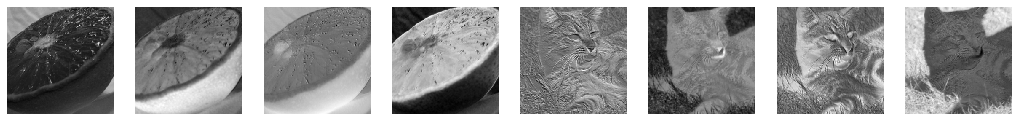

Conv2's Feature Map (Image 1&2): 


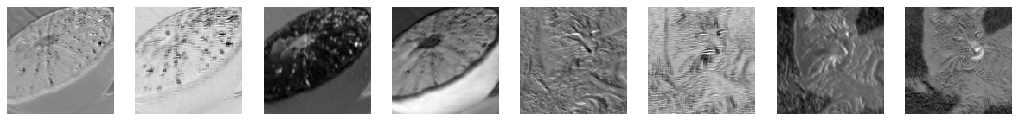

Conv3's Feature Map (Image 1&2): 


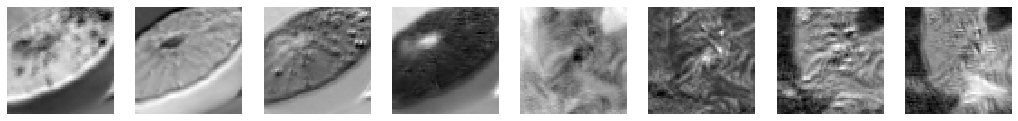

Conv4's Feature Map (Image 1&2): 


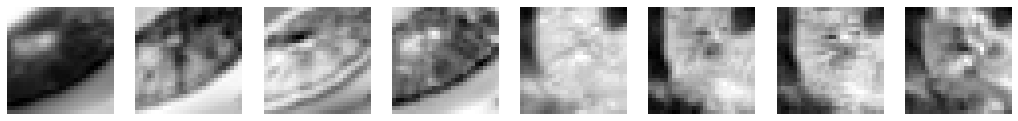

In [48]:
feature_map()